In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils


import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

import numpy as np
import random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Hyperparameters

In [2]:
epochs = 20
batch_size = 4

## Loading data

In [3]:

train_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_train.csv'
test_p = r'C:\Users\huyen\OneDrive - UNT System\A_PhD_PATH\COURSES\CSCE 5218\Project\Computer-Vision-Project\Computer-Vision-Project\data\asl_data\sign_mnist_valid.csv'
train_data = pd.read_csv(train_p,  sep=',')
test_data = pd.read_csv(test_p,  sep=',')
print(f'Train set shape: {train_data.shape}. Test set shape: {test_data.shape}')

Train set shape: (27455, 785). Test set shape: (7172, 785)


In [4]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [5]:
n_classes = len(set(list(train_data['label'])+list(test_data['label'])))
print('number of classes: ', n_classes)

number of classes:  24


## Preparing data

### Spliting data

In [6]:
_y_train = train_data['label']
y_test = test_data['label']
del train_data['label']
del test_data['label']

_X_train = train_data.values.reshape(-1,1,28,28)
X_test = test_data.values.reshape(-1,1,28,28)


In [7]:
# Spliting the training data into two sets for training and validation
X_train, X_val, y_train, y_val = train_test_split(_X_train, _y_train, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}. y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}. y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}. y_test shape: {y_test.shape}')

X_train shape: (21964, 1, 28, 28). y_train shape: (21964,)
X_val shape: (5491, 1, 28, 28). y_val shape: (5491,)
X_test shape: (7172, 1, 28, 28). y_test shape: (7172,)


### Showing some image and label examples

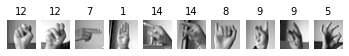

In [8]:
# Showing image examples
def show_imgs(feature_lists, labels):
    for i, (features, label) in enumerate(zip (feature_lists, labels)):
        image = features.reshape(28, 28)
        plt.subplot(1, len(labels), i+1)
        plt.title(label, fontdict={'fontsize': 10})
        plt.axis('off')
        plt.imshow(image, cmap='gray')

show_imgs(X_train[15:25], y_train[15:25])

### Normalize the data


In [9]:
# Exploring min and max values of image pixels
print(f'X_train: min= {X_train.min()}, max={X_train.max()}')

# Normalize images by dividing pixel values by the max
X_train = X_train/255
X_val = X_val/255
X_test = X_test/255

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

print(f'X_train: min= {X_train.min()}, max={X_train.max()}')
print(f'X_val: min= {X_val.min()}, max={X_val.max()}')
print(f'X_test: min= {X_test.min()}, max={X_test.max()}')

X_train: min= 0, max=255
X_train: min= 0.0, max=1.0
X_val: min= 0.0, max=1.0
X_test: min= 0.0, max=1.0


In [10]:
# Exploring the class labels to consider encoding them if neccessary
n_classes

24

### Loading data to Dataset and Dataloader object

In [11]:

class CustomDataset():
    def __init__(self, X, Y) -> None:
        super(CustomDataset, self).__init__()
        self.X = X
        self.Y = Y
        # print(type(self.X), type(self.Y))


    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.Y[idx]
        self.x_tensor = torch.tensor(x, dtype = torch.float) #float32
        self.y_tensor = torch.tensor(y, dtype = torch.long)
        return self.x_tensor, self.y_tensor

# passing data to the customized dataset class we created
train_datatensor = CustomDataset(X_train, y_train)
val_datatensor = CustomDataset(X_val, y_val)
test_datatensor = CustomDataset(X_test, y_test)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )
test_dataloader = DataLoader(test_datatensor, sampler = torch.utils.data.SequentialSampler(test_datatensor), batch_size=batch_size )



In [12]:
'''
X_train_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)
y_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)

X_val_tensor = torch.from_numpy(X_val).type(torch.FloatTensor)
y_val_tensor = torch.from_numpy(y_val).type(torch.LongTensor)

X_test_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)
y_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)

# passing data to the customized dataset class we created
train_datatensor = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_datatensor = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_datatensor = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# loading datasets to pytorch dataloader object
train_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )
val_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_size=batch_size )
test_dataloader = DataLoader(test_datatensor, sampler = torch.utils.data.SequentialSampler(test_datatensor), batch_size=batch_size )
'''

'\nX_train_tensor = torch.from_numpy(X_train).type(torch.FloatTensor)\ny_train_tensor = torch.from_numpy(y_train).type(torch.LongTensor)\n\nX_val_tensor = torch.from_numpy(X_val).type(torch.FloatTensor)\ny_val_tensor = torch.from_numpy(y_val).type(torch.LongTensor)\n\nX_test_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)\ny_test_tensor = torch.from_numpy(y_test).type(torch.LongTensor)\n\n# passing data to the customized dataset class we created\ntrain_datatensor = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)\nval_datatensor = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)\ntest_datatensor = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)\n\n# loading datasets to pytorch dataloader object\ntrain_dataloader = DataLoader(train_datatensor, sampler = torch.utils.data.RandomSampler(train_datatensor), batch_size=batch_size )\nval_dataloader = DataLoader(val_datatensor, sampler = torch.utils.data.SequentialSampler(val_datatensor), batch_siz

In [13]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([4, 1, 28, 28])
Labels batch shape: torch.Size([4])


## Creating model

In [14]:
class CNNNet(nn.Module):
    def __init__(self, n_classes) -> None:
        super(CNNNet, self).__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=1, stride=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=1, stride=1)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.dropout1 = nn.Dropout2d(0.2)
        self.dropout2 = nn.Dropout2d(0.3)

        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, self.n_classes)
        self.fc3 = nn.Softmax(dim=1)

    def forward(self, x):
        # print('input x', x.size())
        x = F.relu(self.conv1(x))
        # x = self.batchnorm1(x)
        x = self.pool1(x)
        # print('after block 1', x.size())

        x = F.relu(self.conv2(x))
        x = self.dropout1(x)
        # x = self.batchnorm2(x)
        x = self.pool2(x)
        # print('after block 2', x.size())

        x = F.relu(self.conv3(x))
        # x = self.batchnorm3(x)
        x = self.pool3(x)
        # print('after block 3', x.size())


        # x = torch.flatten(x, -1)
        x = x.view(-1,3*3*64 )
        # x = x.view(x.size(0), -1)
        # print('after flattening', x.size())
        '''
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        '''
        x = self.fc1(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return self.fc3(x)


model= CNNNet(n_classes = n_classes)
print(model)

CNNNet(
  (conv1): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.2, inplace=False)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (fc1): Linear(in_features=576, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=24, bias=True)
  (fc3): Softmax(dim=1)
)


In [15]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)

## Training model

In [16]:
def get_accuracy (y_true, y_pred):
    return (y_pred == y_true).sum().item()/len(y_true)

def train_fn(data_loader, model, optimizer, device):
    model.train()
    final_loss = 0.0
    for i, data in enumerate(tqdm(data_loader, total = len(data_loader))):
        # get input, and send to device
        inputs, labels = data[0].to(device), data[1].to(device) #, torch.float, , dtype=torch.int64
        # zero the gradient
        optimizer.zero_grad()

        # forward
        outputs = model(inputs) 
        _, pred_labels = torch.max(outputs.data, 1)
        loss = loss_fn(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()
        
        # print loss every 1000 steps
        if (i+1) % 1000 == 0:
            print(f'Step [{i+1}/{len(data_loader)}]: Loss = {loss.item()}, Accuracy = {get_accuracy(labels, pred_labels)}')

        # save loss
        final_loss +=loss.item()
    return final_loss/len(data_loader)


def eval_fn(data_loader, model):
    model.eval()
    total = 0
    correct = 0
    final_loss = 0.0
    predictions = []
    with torch.no_grad():
        for data in tqdm(data_loader, total = len(data_loader)):
            inputs, labels = data
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            final_loss +=loss.item()

            _, pred_labels = torch.max(outputs.data, 1)
            predictions.append(pred_labels)
            # print('labels.size(0)', labels.size(0))
            total+= 1 #labels.size(0)
            correct+= get_accuracy(labels, pred_labels)
            # print(f'correct / total: {correct} / {total}')

    return final_loss/len(data_loader), correct / total, predictions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)    

train_loss_values, validation_loss_values = [], []
best_loss = np.inf

for epoch in range(epochs):
    train_loss = train_fn(train_dataloader, model, optimizer, device)
    train_loss_values.append(train_loss)
    
    val_loss, val_accuracy, _ = eval_fn(val_dataloader, model)
    validation_loss_values.append(val_loss)

    # saving the best model
    checkpoint_p = './asl.pth'
    if val_loss < best_loss:
        torch.save(model.state_dict(), checkpoint_p)
        best_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
    print(f'Epoch {epoch+1}/{epochs}: Train loss = {train_loss}, Validation loss = {val_loss}, Validation accuracy: {val_accuracy:.4f}')




  0%|          | 0/5491 [00:00<?, ?it/s]C:\Users\huyen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
 19%|█▊        | 1023/5491 [00:07<00:29, 153.13it/s]

Step [1000/5491]: Loss = 3.175443172454834, Accuracy = 0.25


 37%|███▋      | 2018/5491 [00:15<00:24, 139.46it/s]

Step [2000/5491]: Loss = 3.1780571937561035, Accuracy = 0.0


 55%|█████▍    | 3008/5491 [00:26<00:38, 64.87it/s] 

Step [3000/5491]: Loss = 3.1747262477874756, Accuracy = 0.0


 73%|███████▎  | 4019/5491 [00:34<00:12, 117.32it/s]

Step [4000/5491]: Loss = 3.177351951599121, Accuracy = 0.25


 91%|█████████▏| 5016/5491 [00:41<00:03, 136.69it/s]

Step [5000/5491]: Loss = 3.175959348678589, Accuracy = 0.0


100%|██████████| 1373/1373 [00:03<00:00, 397.89it/s]


Epoch 1/20: Train loss = 3.17789742191553, Validation loss = 3.1778204421969285, Validation accuracy: 0.0475


 18%|█▊        | 1013/5491 [00:08<00:37, 120.40it/s]

Step [1000/5491]: Loss = 3.179746627807617, Accuracy = 0.0


 37%|███▋      | 2026/5491 [00:28<00:25, 138.42it/s]

Step [2000/5491]: Loss = 3.177309513092041, Accuracy = 0.0


 55%|█████▌    | 3029/5491 [00:35<00:14, 165.65it/s]

Step [3000/5491]: Loss = 3.1794705390930176, Accuracy = 0.0


 73%|███████▎  | 4028/5491 [00:41<00:10, 142.98it/s]

Step [4000/5491]: Loss = 3.1815950870513916, Accuracy = 0.0


 92%|█████████▏| 5031/5491 [00:50<00:03, 152.52it/s]

Step [5000/5491]: Loss = 3.1716036796569824, Accuracy = 0.0


100%|██████████| 1373/1373 [00:03<00:00, 397.49it/s]


Epoch 2/20: Train loss = 3.1776969850964285, Validation loss = 3.177621007052461, Validation accuracy: 0.0475


 19%|█▊        | 1021/5491 [00:08<00:30, 147.23it/s]

Step [1000/5491]: Loss = 3.1829466819763184, Accuracy = 0.0


 37%|███▋      | 2021/5491 [00:15<00:22, 154.42it/s]

Step [2000/5491]: Loss = 3.175215721130371, Accuracy = 0.0


 55%|█████▌    | 3021/5491 [00:23<00:18, 134.99it/s]

Step [3000/5491]: Loss = 3.1745901107788086, Accuracy = 0.25


 73%|███████▎  | 4013/5491 [00:30<00:12, 119.64it/s]

Step [4000/5491]: Loss = 3.1757233142852783, Accuracy = 0.0


 92%|█████████▏| 5025/5491 [00:37<00:02, 160.45it/s]

Step [5000/5491]: Loss = 3.1759817600250244, Accuracy = 0.0


100%|██████████| 1373/1373 [00:04<00:00, 311.08it/s]


Epoch 3/20: Train loss = 3.1775272928980223, Validation loss = 3.177379514384426, Validation accuracy: 0.0475


 19%|█▊        | 1025/5491 [00:08<00:30, 146.24it/s]

Step [1000/5491]: Loss = 3.1668219566345215, Accuracy = 0.25


 37%|███▋      | 2017/5491 [00:15<00:27, 124.10it/s]

Step [2000/5491]: Loss = 3.174553871154785, Accuracy = 0.0


 55%|█████▍    | 3020/5491 [00:23<00:18, 135.79it/s]

Step [3000/5491]: Loss = 3.1800575256347656, Accuracy = 0.0


 73%|███████▎  | 4032/5491 [00:31<00:09, 161.90it/s]

Step [4000/5491]: Loss = 3.180788993835449, Accuracy = 0.0


 91%|█████████▏| 5014/5491 [00:37<00:03, 154.29it/s]

Step [5000/5491]: Loss = 3.1738338470458984, Accuracy = 0.0


100%|██████████| 1373/1373 [00:04<00:00, 341.81it/s]


Epoch 4/20: Train loss = 3.1773288397162887, Validation loss = 3.1770667368186625, Validation accuracy: 0.0475


 19%|█▊        | 1027/5491 [00:07<00:28, 159.41it/s]

Step [1000/5491]: Loss = 3.1802468299865723, Accuracy = 0.0


 37%|███▋      | 2017/5491 [00:14<00:33, 103.88it/s]

Step [2000/5491]: Loss = 3.175713062286377, Accuracy = 0.0


 55%|█████▍    | 3018/5491 [00:23<00:18, 131.47it/s]

Step [3000/5491]: Loss = 3.171767234802246, Accuracy = 0.0


 73%|███████▎  | 4013/5491 [00:30<00:10, 138.85it/s]

Step [4000/5491]: Loss = 3.17744517326355, Accuracy = 0.0


 91%|█████████▏| 5020/5491 [00:42<00:03, 135.48it/s]

Step [5000/5491]: Loss = 3.1815195083618164, Accuracy = 0.0


100%|██████████| 1373/1373 [00:05<00:00, 252.34it/s]


Epoch 5/20: Train loss = 3.1769739214220327, Validation loss = 3.176624188176577, Validation accuracy: 0.0475


 19%|█▊        | 1021/5491 [00:07<00:30, 145.75it/s]

Step [1000/5491]: Loss = 3.1907920837402344, Accuracy = 0.0


 37%|███▋      | 2020/5491 [00:16<00:25, 133.87it/s]

Step [2000/5491]: Loss = 3.159695625305176, Accuracy = 0.25


 55%|█████▍    | 3020/5491 [00:25<00:17, 139.77it/s]

Step [3000/5491]: Loss = 3.1800334453582764, Accuracy = 0.0


 73%|███████▎  | 4017/5491 [00:35<00:11, 130.34it/s]

Step [4000/5491]: Loss = 3.1896414756774902, Accuracy = 0.0


 91%|█████████ | 5006/5491 [00:44<00:06, 70.25it/s] 

Step [5000/5491]: Loss = 3.1511807441711426, Accuracy = 0.25


100%|██████████| 1373/1373 [00:04<00:00, 325.71it/s]


Epoch 6/20: Train loss = 3.1767161237240447, Validation loss = 3.1760218131307782, Validation accuracy: 0.0475


 18%|█▊        | 1011/5491 [00:09<00:51, 86.23it/s]

Step [1000/5491]: Loss = 3.1942896842956543, Accuracy = 0.0


 37%|███▋      | 2021/5491 [00:20<00:35, 97.33it/s] 

Step [2000/5491]: Loss = 3.176994800567627, Accuracy = 0.0


 55%|█████▍    | 3019/5491 [00:29<00:20, 119.05it/s]

Step [3000/5491]: Loss = 3.1884679794311523, Accuracy = 0.0


 73%|███████▎  | 4015/5491 [00:39<00:12, 115.91it/s]

Step [4000/5491]: Loss = 3.1930477619171143, Accuracy = 0.0


 91%|█████████▏| 5012/5491 [00:53<00:06, 76.35it/s] 

Step [5000/5491]: Loss = 3.193654775619507, Accuracy = 0.0


100%|██████████| 1373/1373 [00:04<00:00, 301.33it/s]


Epoch 7/20: Train loss = 3.176422172286562, Validation loss = 3.175198167236895, Validation accuracy: 0.0530


 19%|█▊        | 1022/5491 [00:10<00:33, 135.22it/s]

Step [1000/5491]: Loss = 3.1728944778442383, Accuracy = 0.0


 37%|███▋      | 2024/5491 [00:19<00:24, 139.76it/s]

Step [2000/5491]: Loss = 3.1394076347351074, Accuracy = 0.25


 55%|█████▍    | 3018/5491 [00:28<00:20, 119.31it/s]

Step [3000/5491]: Loss = 3.192993402481079, Accuracy = 0.0


 73%|███████▎  | 4013/5491 [00:41<00:11, 127.74it/s]

Step [4000/5491]: Loss = 3.170574188232422, Accuracy = 0.0


 91%|█████████▏| 5013/5491 [00:51<00:03, 129.73it/s]

Step [5000/5491]: Loss = 3.1964216232299805, Accuracy = 0.0


100%|██████████| 1373/1373 [00:06<00:00, 227.08it/s]


Epoch 8/20: Train loss = 3.1757537791950847, Validation loss = 3.1738101845662783, Validation accuracy: 0.0530


 18%|█▊        | 1011/5491 [00:12<03:20, 22.34it/s]

Step [1000/5491]: Loss = 3.199976682662964, Accuracy = 0.0


 37%|███▋      | 2018/5491 [00:21<00:27, 126.95it/s]

Step [2000/5491]: Loss = 3.153576374053955, Accuracy = 0.0


 55%|█████▌    | 3021/5491 [00:29<00:20, 120.67it/s]

Step [3000/5491]: Loss = 3.0925920009613037, Accuracy = 0.25


 73%|███████▎  | 4020/5491 [00:37<00:11, 132.56it/s]

Step [4000/5491]: Loss = 3.2064766883850098, Accuracy = 0.0


 91%|█████████▏| 5023/5491 [00:44<00:03, 140.06it/s]

Step [5000/5491]: Loss = 3.1804933547973633, Accuracy = 0.0


100%|██████████| 1373/1373 [00:03<00:00, 367.95it/s]


Epoch 9/20: Train loss = 3.173765136383201, Validation loss = 3.168214152698003, Validation accuracy: 0.0544


 19%|█▊        | 1026/5491 [00:07<00:28, 154.91it/s]

Step [1000/5491]: Loss = 3.214630603790283, Accuracy = 0.0


 37%|███▋      | 2019/5491 [00:14<00:24, 144.53it/s]

Step [2000/5491]: Loss = 3.188478469848633, Accuracy = 0.0


 55%|█████▍    | 3014/5491 [00:21<00:16, 150.95it/s]

Step [3000/5491]: Loss = 3.2019152641296387, Accuracy = 0.0


 73%|███████▎  | 4017/5491 [00:28<00:09, 156.20it/s]

Step [4000/5491]: Loss = 3.1232943534851074, Accuracy = 0.25


 91%|█████████▏| 5011/5491 [00:34<00:03, 144.25it/s]

Step [5000/5491]: Loss = 3.188262701034546, Accuracy = 0.0


100%|██████████| 1373/1373 [00:05<00:00, 269.69it/s]


Epoch 10/20: Train loss = 3.166431311418224, Validation loss = 3.1539505425805343, Validation accuracy: 0.0978


 19%|█▊        | 1019/5491 [00:07<00:28, 155.41it/s]

Step [1000/5491]: Loss = 3.2099437713623047, Accuracy = 0.0


 37%|███▋      | 2026/5491 [00:13<00:22, 153.33it/s]

Step [2000/5491]: Loss = 3.208364248275757, Accuracy = 0.0


 55%|█████▌    | 3021/5491 [00:21<00:16, 146.22it/s]

Step [3000/5491]: Loss = 2.9879255294799805, Accuracy = 0.25


 73%|███████▎  | 4022/5491 [00:28<00:09, 149.59it/s]

Step [4000/5491]: Loss = 3.0089550018310547, Accuracy = 0.25


 92%|█████████▏| 5025/5491 [00:35<00:03, 146.63it/s]

Step [5000/5491]: Loss = 2.9067044258117676, Accuracy = 0.25


100%|██████████| 1373/1373 [00:03<00:00, 354.63it/s]


Epoch 11/20: Train loss = 3.145915107548161, Validation loss = 3.1191994779229772, Validation accuracy: 0.1302


 19%|█▊        | 1016/5491 [00:07<00:31, 142.11it/s]

Step [1000/5491]: Loss = 3.2178220748901367, Accuracy = 0.0


 37%|███▋      | 2005/5491 [00:16<00:27, 126.87it/s]

Step [2000/5491]: Loss = 3.2372031211853027, Accuracy = 0.0


 55%|█████▍    | 3018/5491 [00:25<00:25, 98.05it/s] 

Step [3000/5491]: Loss = 2.984762668609619, Accuracy = 0.25


 73%|███████▎  | 4018/5491 [00:33<00:12, 119.05it/s]

Step [4000/5491]: Loss = 3.0886456966400146, Accuracy = 0.25


 91%|█████████▏| 5020/5491 [00:42<00:04, 117.66it/s]

Step [5000/5491]: Loss = 3.026442766189575, Accuracy = 0.25


100%|██████████| 1373/1373 [00:04<00:00, 279.37it/s]


Epoch 12/20: Train loss = 3.1076117860578356, Validation loss = 3.077552503855317, Validation accuracy: 0.1817


 19%|█▊        | 1022/5491 [00:07<00:31, 141.73it/s]

Step [1000/5491]: Loss = 3.230506658554077, Accuracy = 0.0


 37%|███▋      | 2020/5491 [00:14<00:37, 93.46it/s] 

Step [2000/5491]: Loss = 3.0153274536132812, Accuracy = 0.25


 55%|█████▌    | 3025/5491 [00:24<00:15, 155.83it/s]

Step [3000/5491]: Loss = 2.8341002464294434, Accuracy = 0.5


 73%|███████▎  | 4015/5491 [00:32<00:31, 46.53it/s] 

Step [4000/5491]: Loss = 2.9857609272003174, Accuracy = 0.25


 91%|█████████▏| 5017/5491 [00:40<00:03, 137.81it/s]

Step [5000/5491]: Loss = 2.6804380416870117, Accuracy = 0.5


100%|██████████| 1373/1373 [00:04<00:00, 283.38it/s]


Epoch 13/20: Train loss = 3.063821264660178, Validation loss = 3.0255417460867373, Validation accuracy: 0.2340


 19%|█▊        | 1016/5491 [00:07<00:30, 146.66it/s]

Step [1000/5491]: Loss = 2.7827308177948, Accuracy = 0.5


 37%|███▋      | 2019/5491 [00:17<00:23, 146.67it/s]

Step [2000/5491]: Loss = 3.2327022552490234, Accuracy = 0.0


 55%|█████▍    | 3012/5491 [00:27<00:19, 126.85it/s]

Step [3000/5491]: Loss = 2.7543253898620605, Accuracy = 0.5


 73%|███████▎  | 4011/5491 [00:35<00:11, 133.62it/s]

Step [4000/5491]: Loss = 2.9844651222229004, Accuracy = 0.25


 91%|█████████▏| 5015/5491 [00:42<00:03, 119.47it/s]

Step [5000/5491]: Loss = 2.9048895835876465, Accuracy = 0.25


100%|██████████| 1373/1373 [00:04<00:00, 283.05it/s]


Epoch 14/20: Train loss = 3.0122133362946713, Validation loss = 2.993152626396007, Validation accuracy: 0.2567


 18%|█▊        | 1010/5491 [00:10<00:59, 75.76it/s]

Step [1000/5491]: Loss = 3.0020716190338135, Accuracy = 0.25


 37%|███▋      | 2011/5491 [00:23<00:41, 83.19it/s]

Step [2000/5491]: Loss = 2.4962143898010254, Accuracy = 0.75


 55%|█████▍    | 3014/5491 [00:34<00:29, 82.95it/s]

Step [3000/5491]: Loss = 2.5482256412506104, Accuracy = 0.75


 73%|███████▎  | 4017/5491 [00:47<00:15, 96.71it/s]

Step [4000/5491]: Loss = 2.9934093952178955, Accuracy = 0.25


 91%|█████████▏| 5012/5491 [00:58<00:05, 91.08it/s] 

Step [5000/5491]: Loss = 2.9907472133636475, Accuracy = 0.25


100%|██████████| 1373/1373 [00:06<00:00, 217.98it/s]


Epoch 15/20: Train loss = 2.9853617372115093, Validation loss = 2.9794493582851245, Validation accuracy: 0.2684


 18%|█▊        | 1011/5491 [00:12<00:53, 84.03it/s]

Step [1000/5491]: Loss = 3.239593029022217, Accuracy = 0.0


 37%|███▋      | 2007/5491 [00:24<00:39, 87.86it/s]

Step [2000/5491]: Loss = 3.2355995178222656, Accuracy = 0.0


 55%|█████▍    | 3008/5491 [00:37<00:29, 85.31it/s]

Step [3000/5491]: Loss = 2.9960739612579346, Accuracy = 0.25


 73%|███████▎  | 4015/5491 [00:50<00:16, 88.04it/s]

Step [4000/5491]: Loss = 2.991823434829712, Accuracy = 0.25


 91%|█████████▏| 5015/5491 [01:02<00:05, 87.64it/s]

Step [5000/5491]: Loss = 2.9967472553253174, Accuracy = 0.25


100%|██████████| 1373/1373 [00:06<00:00, 210.58it/s]


Epoch 16/20: Train loss = 2.969766327340927, Validation loss = 2.9516797630090568, Validation accuracy: 0.2957


 18%|█▊        | 1012/5491 [00:12<01:06, 67.10it/s]

Step [1000/5491]: Loss = 3.2363319396972656, Accuracy = 0.0


 37%|███▋      | 2014/5491 [00:25<00:37, 91.99it/s]

Step [2000/5491]: Loss = 3.2410874366760254, Accuracy = 0.0


 55%|█████▍    | 3016/5491 [00:39<00:26, 92.78it/s]

Step [3000/5491]: Loss = 2.8128814697265625, Accuracy = 0.5


 73%|███████▎  | 4013/5491 [00:50<00:16, 87.81it/s]

Step [4000/5491]: Loss = 3.1752521991729736, Accuracy = 0.0


 91%|█████████▏| 5014/5491 [01:02<00:05, 91.44it/s] 

Step [5000/5491]: Loss = 2.887427806854248, Accuracy = 0.5


100%|██████████| 1373/1373 [00:20<00:00, 67.03it/s] 


Epoch 17/20: Train loss = 2.945211130377374, Validation loss = 2.90135719614661, Validation accuracy: 0.3567


 18%|█▊        | 1010/5491 [00:13<00:51, 86.75it/s]

Step [1000/5491]: Loss = 2.7466726303100586, Accuracy = 0.5


 37%|███▋      | 2012/5491 [00:25<00:40, 85.74it/s]

Step [2000/5491]: Loss = 2.982682228088379, Accuracy = 0.25


 55%|█████▍    | 3017/5491 [00:38<00:31, 79.65it/s]

Step [3000/5491]: Loss = 2.9671034812927246, Accuracy = 0.25


 73%|███████▎  | 4010/5491 [00:52<00:21, 70.27it/s]

Step [4000/5491]: Loss = 3.133586883544922, Accuracy = 0.0


 91%|█████████ | 5009/5491 [01:04<00:06, 78.50it/s]

Step [5000/5491]: Loss = 2.78014874458313, Accuracy = 0.5


100%|██████████| 1373/1373 [00:06<00:00, 215.71it/s]


Epoch 18/20: Train loss = 2.907962999064248, Validation loss = 2.8789528225428502, Validation accuracy: 0.3736


 18%|█▊        | 1007/5491 [00:12<01:12, 61.76it/s]

Step [1000/5491]: Loss = 2.506162643432617, Accuracy = 0.75


 37%|███▋      | 2014/5491 [00:24<00:50, 68.78it/s]

Step [2000/5491]: Loss = 3.2464382648468018, Accuracy = 0.0


 55%|█████▍    | 3013/5491 [00:37<00:28, 87.07it/s]

Step [3000/5491]: Loss = 2.9962542057037354, Accuracy = 0.25


 73%|███████▎  | 4009/5491 [00:49<00:17, 83.22it/s]

Step [4000/5491]: Loss = 2.9780545234680176, Accuracy = 0.25


 91%|█████████▏| 5016/5491 [01:01<00:05, 79.62it/s] 

Step [5000/5491]: Loss = 3.2314939498901367, Accuracy = 0.0


100%|██████████| 1373/1373 [00:06<00:00, 223.75it/s]


Epoch 19/20: Train loss = 2.8969069363054434, Validation loss = 2.8627196335914094, Validation accuracy: 0.3882


 18%|█▊        | 1007/5491 [00:13<01:14, 59.89it/s]

Step [1000/5491]: Loss = 2.5305683612823486, Accuracy = 0.75


 37%|███▋      | 2011/5491 [00:26<00:41, 84.25it/s]

Step [2000/5491]: Loss = 2.768057107925415, Accuracy = 0.5


 55%|█████▍    | 3006/5491 [00:37<00:25, 96.88it/s] 

Step [3000/5491]: Loss = 2.744553327560425, Accuracy = 0.5


 73%|███████▎  | 4014/5491 [00:51<00:18, 81.92it/s]

Step [4000/5491]: Loss = 2.9825048446655273, Accuracy = 0.25


 91%|█████████ | 5008/5491 [01:05<00:06, 72.16it/s]

Step [5000/5491]: Loss = 2.9972643852233887, Accuracy = 0.25


100%|██████████| 1373/1373 [00:07<00:00, 183.14it/s]

Epoch 20/20: Train loss = 2.8892065850009336, Validation loss = 2.8637688772919745, Validation accuracy: 0.3864


## Testing model

In [17]:
model.load_state_dict(best_model_wts)
_, test_accuracy, test_preds = eval_fn(test_dataloader, model)
print(f'Model performance on test set: Accuracy = {test_accuracy}')

100%|██████████| 1793/1793 [00:09<00:00, 196.38it/s]

Model performance on test set: Accuracy = 0.2639431121026213
